# **Point cloud classification**


## **Introduction**

Classification, detection and segmentation of unordered 3D point sets i.e. point clouds
is a core problem in computer vision. This example implements the seminal point cloud
deep learning paper [PointNet (Qi et al., 2017)](https://arxiv.org/abs/1612.00593). For a
detailed intoduction on PointNet see [this blog
post](https://medium.com/@luis_gonzales/an-in-depth-look-at-pointnet-111d7efdaa1a).

### **What are Point Clouds?**

A point cloud is a set of data points in space. The points may represent a 3D shape or object.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Extract_Video_Beit_Ghazaleh_Orthophoto_Survey_AG%26P_2017.gif/440px-Extract_Video_Beit_Ghazaleh_Orthophoto_Survey_AG%26P_2017.gif)


## Setup

If using colab first install trimesh with `!pip install trimesh`.


In [2]:
%pip install trimesh

     -------------------------------------- 688.5/688.5 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: C:\Users\hasee\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [64]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tqdm import tqdm
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping



tf.random.set_seed(1234)

## Load dataset

We use the ModelNet10 model dataset, the smaller 10 class version of the ModelNet40
dataset. First download the data:


In [2]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

'DATA_DIR = tf.keras.utils.get_file(\n    "modelnet.zip",\n    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",\n    extract=True,\n)\nDATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")'

### If you have already downloaded dataset then replace following path with your dataset path

In [3]:
import os

# Replace 'path_to_your_downloaded_modelnet10_data' with the actual path on your machine
DATA_DIR = 'DataSets/modelnet10/ModelNet10/ModelNet10'

# Optionally, you may want to check if the directory exists
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"The directory '{DATA_DIR}' does not exist.")

We can use the `trimesh` package to read and visualize the `.off` mesh files.


In [6]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0003.off"))
mesh.show()

To convert a mesh file to a point cloud we first need to sample points on the mesh
surface. `.sample()` performs a unifrom random sampling. Here we sample at 2048 locations
and visualize in `matplotlib`.


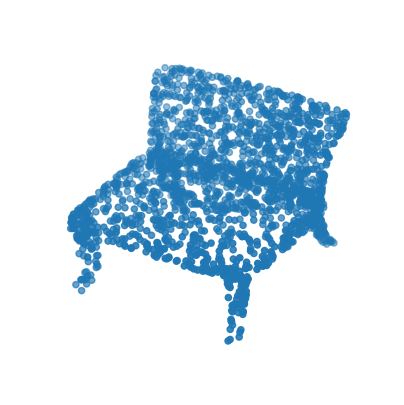

In [8]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

To generate a `tf.data.Dataset()` we need to first parse through the ModelNet data
folders. Each mesh is loaded and sampled into a point cloud before being added to a
standard python list and converted to a `numpy` array. We also store the current
enumerate index value as the object label and use a dictionary to recall this later.


In [39]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))
    #print(folders)
    for i, folder in tqdm(enumerate(folders)):
        #print("I = ", i)
        #print("folder =  ", folder)
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = os.path.basename(folder) #folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)
    print(class_map)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

Set the number of points to sample and batch size and parse the dataset. This can take
~5minutes to complete.


In [40]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

0it [00:00, ?it/s]

processing class: bathtub


1it [00:06,  6.91s/it]

processing class: bed


2it [00:42, 23.73s/it]

processing class: chair


3it [01:43, 40.82s/it]

processing class: night_stand


4it [01:50, 27.59s/it]

processing class: sofa


5it [02:47, 37.98s/it]

processing class: table


6it [03:03, 30.71s/it]

processing class: toilet


7it [03:31, 30.19s/it]

{0: 'bathtub', 1: 'bed', 2: 'chair', 3: 'night_stand', 4: 'sofa', 5: 'table', 6: 'toilet'}


Our data can now be read into a `tf.data.Dataset()` object. We set the shuffle buffer
size to the entire size of the dataset as prior to this the data is ordered by class.
Data augmentation is important when working with point cloud data. We create a
augmentation function to jitter and shuffle the train dataset.


In [41]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

### Build a model

Each convolution and fully-connected layer (with exception for end layers) consits of
Convolution / Dense -> Batch Normalization -> ReLU Activation.


In [42]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

PointNet consists of two core components. The primary MLP network, and the transformer
net (T-net). The T-net aims to learn an affine transformation matrix by its own mini
network. The T-net is used twice. The first time to transform the input features (n, 3)
into a canonical representation. The second is an affine transformation for alignment in
feature space (n, 3). As per the original paper we constrain the transformation to be
close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).


In [43]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

 We can then define a general function to build T-net layers.


In [44]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

The main network can be then implemented in the same manner where the t-net mini models
can be dropped in a layers in the graph. Here we replicate the network architecture
published in the original paper but with half the number of weights at each layer as we
are using the smaller 10 class ModelNet dataset.


In [45]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 2048, 32)     128         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 2048, 32)    128         ['conv1d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 2048, 32)     0           ['batch_normalization_17[0

 activation_26 (Activation)     (None, 2048, 512)    0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 global_max_pooling1d_4 (Global  (None, 512)         0           ['activation_26[0][0]']          
 MaxPooling1D)                                                                                    
                                                                                                  
 dense_12 (Dense)               (None, 256)          131328      ['global_max_pooling1d_4[0][0]'] 
                                                                                                  
 batch_normalization_27 (BatchN  (None, 256)         1024        ['dense_12[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activatio

### Train model

Once the model is defined it can be trained like any other standard classification model
using `.compile()` and `.fit()`.


In [65]:
# Define the callbacks
csv_logger = CSVLogger('Logs/68.Point_Cloud_training.csv', separator=',', append=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

# Fit the model with the callbacks
model.fit(
    train_dataset,
    epochs=100,
    validation_data=test_dataset,
    callbacks=[csv_logger, early_stopping]
)


Epoch 1/100
98/98 [==============================] - 238s 2s/step - loss: 1.6026 - sparse_categorical_accuracy: 0.8372 - val_loss: 3.7475 - val_sparse_categorical_accuracy: 0.4858
Epoch 2/100
98/98 [==============================] - 223s 2s/step - loss: 1.6447 - sparse_categorical_accuracy: 0.8356 - val_loss: 3.5436 - val_sparse_categorical_accuracy: 0.7814
Epoch 3/100
98/98 [==============================] - 228s 2s/step - loss: 1.5664 - sparse_categorical_accuracy: 0.8506 - val_loss: 1138095554560.0000 - val_sparse_categorical_accuracy: 0.9119
Epoch 4/100
98/98 [==============================] - 232s 2s/step - loss: 1.4929 - sparse_categorical_accuracy: 0.8602 - val_loss: 666768198668851871744.0000 - val_sparse_categorical_accuracy: 0.8192
Epoch 5/100
98/98 [==============================] - 235s 2s/step - loss: 1.5150 - sparse_categorical_accuracy: 0.8576 - val_loss: 5.2071 - val_sparse_categorical_accuracy: 0.7579
Epoch 6/100
98/98 [==============================] - 258s 3s/step - 

## Visualize predictions

We can use matplotlib to visualize our trained model performance.


1/1 [==============================] - 1s 1s/step


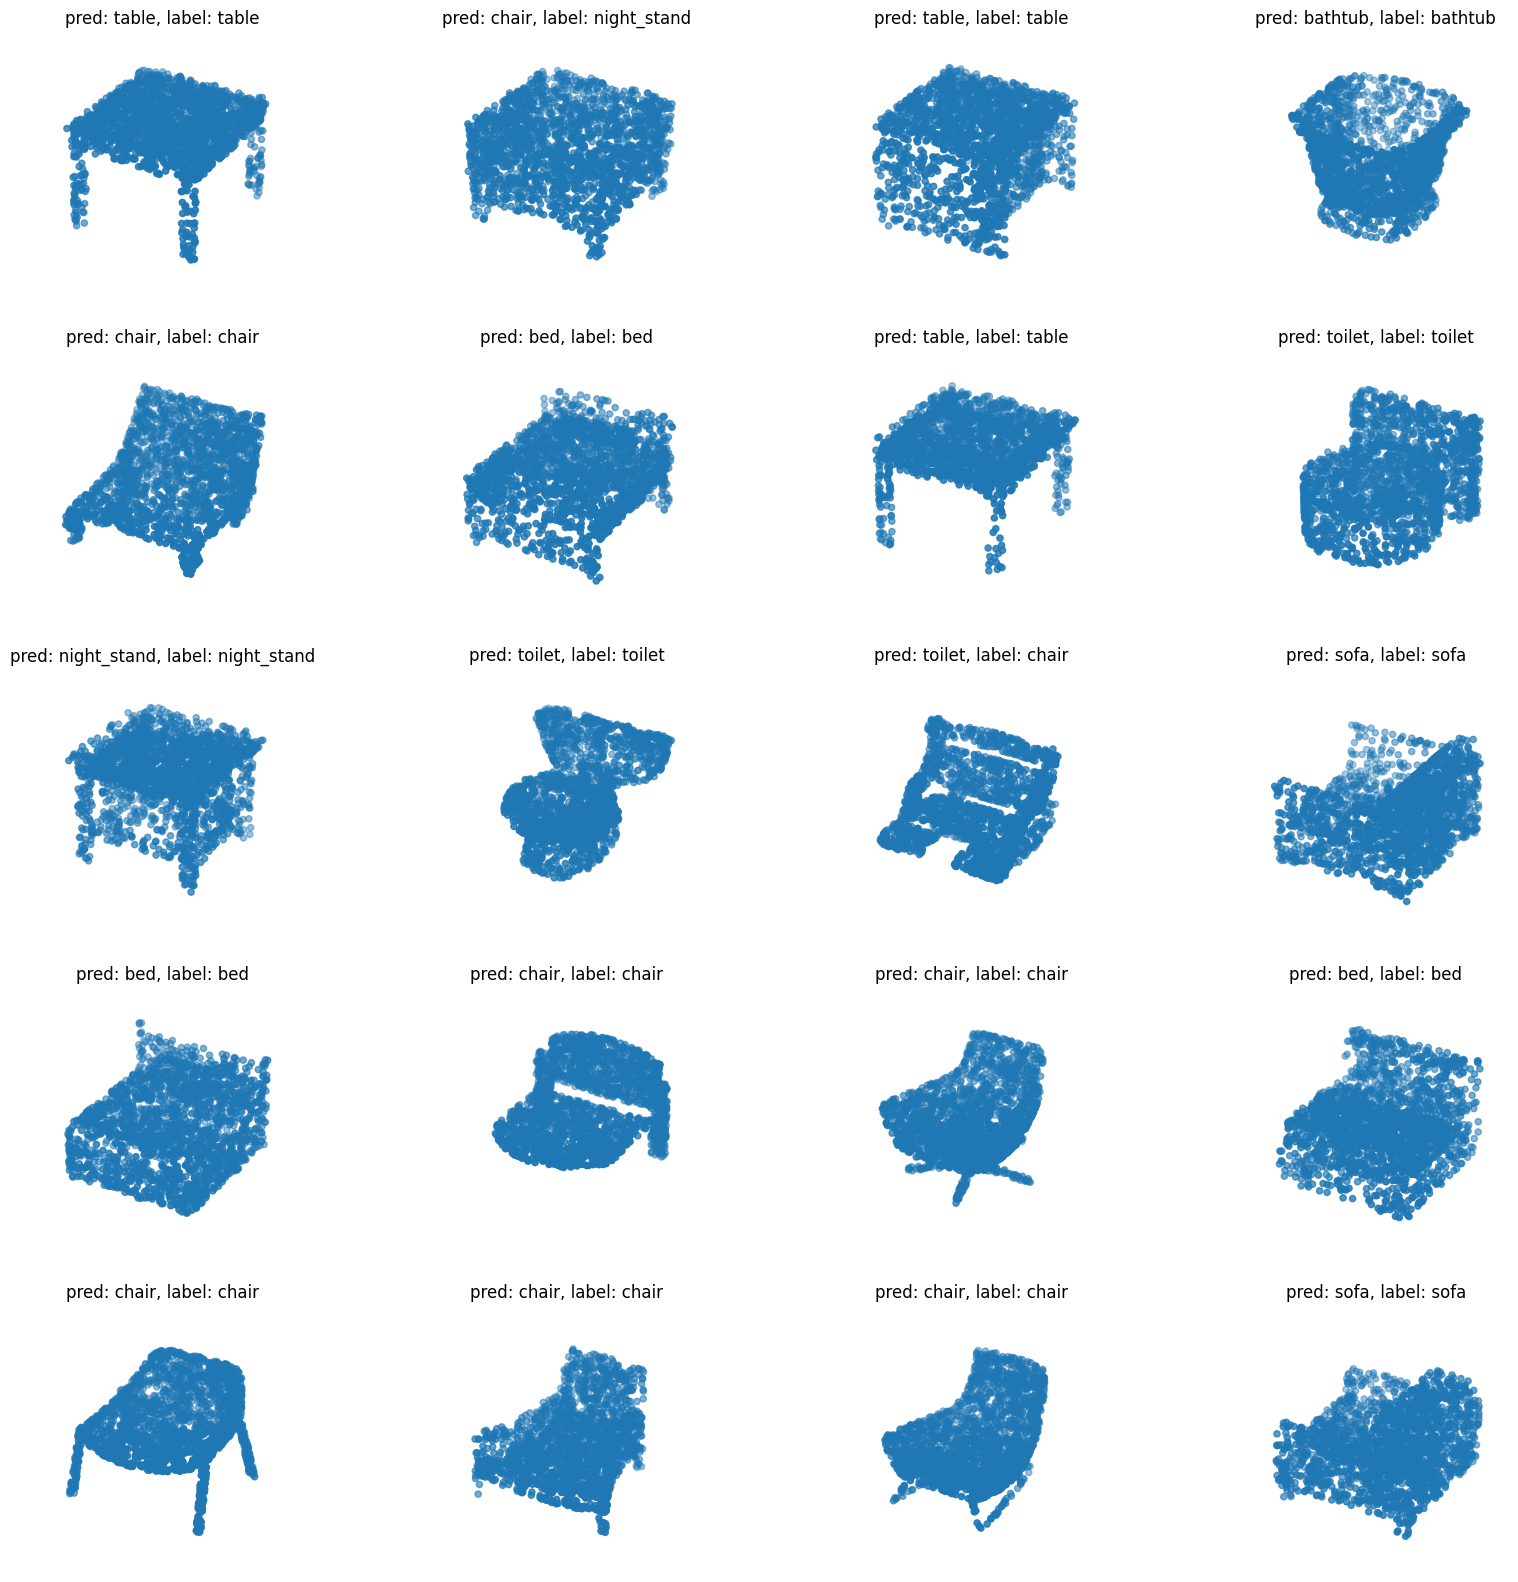

In [66]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(20, 20))
for i in range(20):
    ax = fig.add_subplot(5, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title("pred: {:}, label: {:}".format(CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]))
    ax.set_axis_off()
plt.show()

In [69]:
model.save_weights('weights/point_clud_classification_weights.h5')